In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [3]:
def print_progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """
    Call in a loop to create a terminal progress bar.
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    sys.stdout.write(f'\r{prefix} |{bar}| {percent}% {suffix}')
    sys.stdout.flush()
    # Print New Line on Complete
    if iteration == total: 
        print()

## 1. Diffusion Limited Aggregation

In [61]:
def diffusion_SOR(initial_grid, objects, tol=1e-5, omega=1.8, max_iter=10000):
    """
    Simulate the 2D diffusion using the Successive Over-Relaxation (SOR) method.
    
    Parameters:
    initial_grid (np.array): The initial grid concentration.
    objects (list of tuples): List of object coordinates in the grid.
    tol (float): The convergence criterion.
    omega (float): The relaxation parameter for SOR.
    max_iter (int): Maximum number of iterations to perform.
    
    Returns:
    np.array: Concentration grid after diffusion process.
    """
    c = np.array(initial_grid) # Copy to avoid modifying the original grid

    for k in range(1, max_iter+1):
        c_old = c.copy()
        for i in range(1, c.shape[0] - 1):  # Skip the first and last rows which are boundary conditions
            for j in range(c.shape[1]):
                jp, jm = (j + 1) % c.shape[1], (j - 1) % c.shape[1] # Periodic boundaries                
                if (i,j) in objects:
                    c[i, j] = 0
                else:
                    c[i, j] = (omega/4) * (c[i+1, j] + c[i-1, j] + c[i, jp] + c[i, jm]) + (1 - omega) * c[i, j]

        delta = np.max(np.abs(c - c_old))
        if delta < tol:
            break
        if k == max_iter:
            print(f"No convergence after max iterations {max_iter}")
            break
    
    return c

def simulate_DLA(initial_grid, grid_size, objects, growth_steps, eta, omega):

    steady_state = initial_grid.copy()
    stop_condition = False
    cluster_objects = objects.copy()

    while growth_steps > 0 and stop_condition == False:
        # solve laplace equation
        steady_state = diffusion_SOR(steady_state, cluster_objects, omega=omega, tol=1e-5, max_iter=5000)

        # get growth candidates
        growth_objects = []
        growth_concentrations = []
        for i in range(0, grid_size - 1):
            for j in range(grid_size):
                neighbors = [(i - 1, j), (i + 1, j), (i, (j + 1) % grid_size), (i, (j - 1) % grid_size)]
                if (i,j) not in cluster_objects and len(set(neighbors).intersection(cluster_objects)) > 0:
                    growth_objects.append((i,j))
                    growth_concentrations.append(steady_state[i,j])

        # using the free parameter, modify the growth probabilities
        growth_concentrations = np.maximum(growth_concentrations, 0) # remove negative concentrations
        growth_concentrations = np.array(growth_concentrations) ** eta

        # Choose a random growth object based on concentrations, grow the object
        growth_object = growth_objects[np.random.choice(len(growth_objects), 
                                                        p=growth_concentrations/np.sum(growth_concentrations))]
        cluster_objects.append(growth_object)
        steady_state[growth_object[0], growth_object[1]] = 0

        # stop when the object reaches the top of the grid
        if growth_object[0] == grid_size - 2:
            stop_condition = True 
        growth_steps -= 1

    return steady_state, cluster_objects

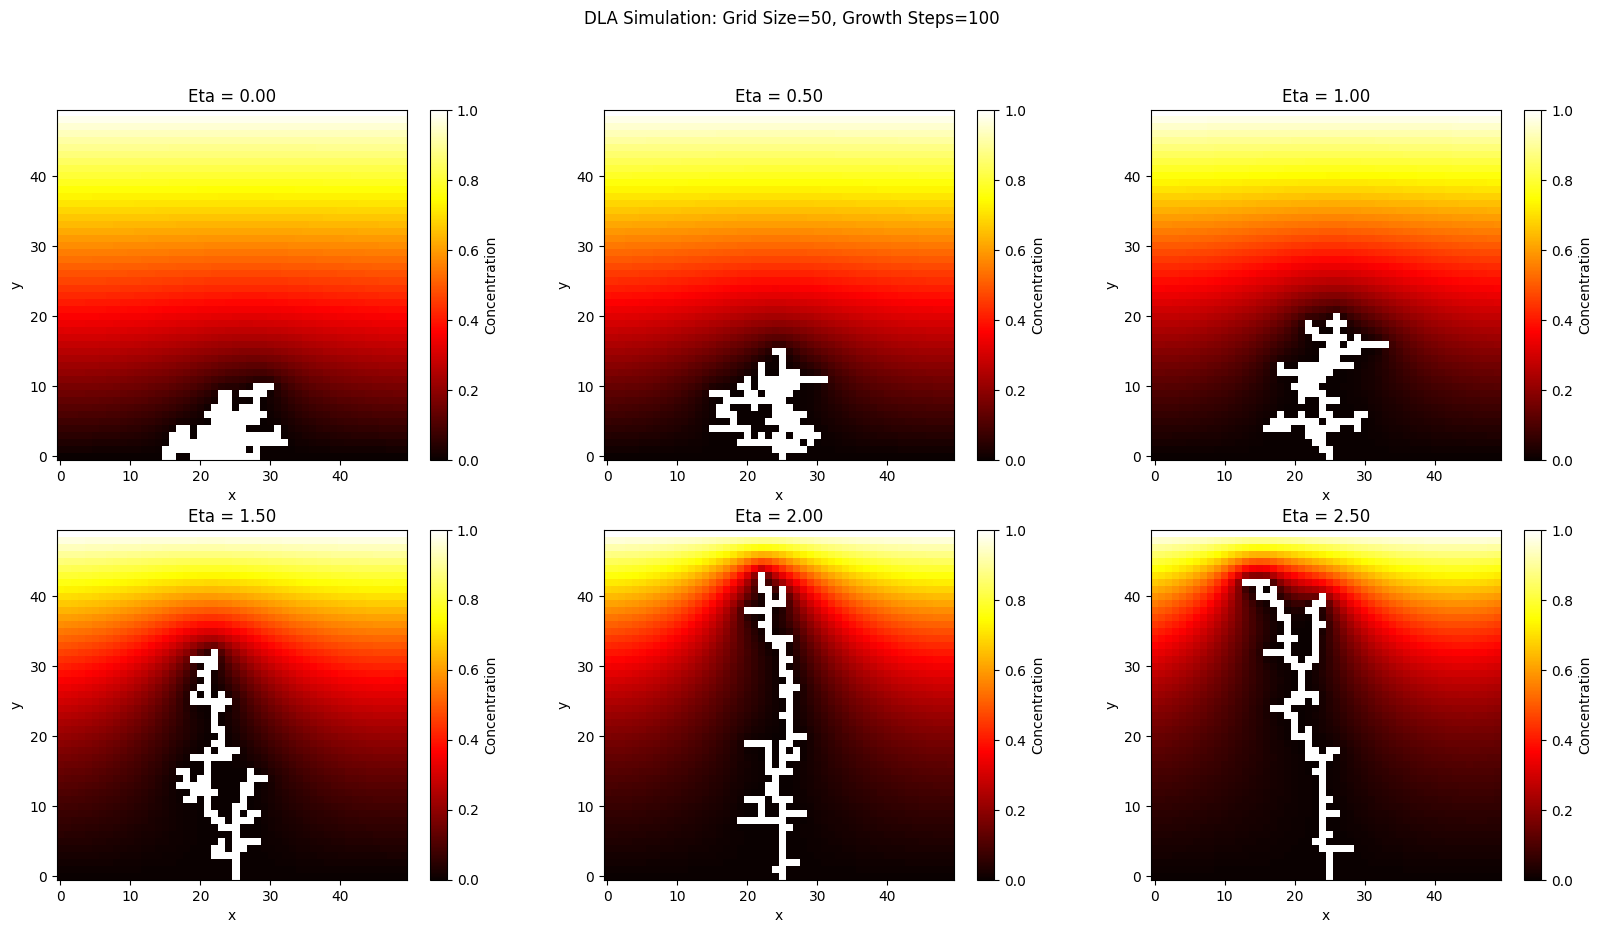

In [73]:
grid_size = 50
initial_grid = np.linspace(0, 1, grid_size).reshape((grid_size, 1)) # linear gradient in the y direction
initial_grid = np.repeat(initial_grid, grid_size, axis=1)
initial_objects = [(0,int(grid_size/2))]
growth_steps = 100
eta = 1.5 # changing this gives different object shapes
omega = 1.90 # optimal omega for grid size 50 from the previous assignment
etas = [0, 0.5, 1.0, 1.5, 2, 2.5]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))

for idx, eta in enumerate(etas):
    row, col = divmod(idx, 3)
    steady_state, objects = simulate_DLA(initial_grid, grid_size, initial_objects, growth_steps, eta, omega)

    for obj in objects:
        # axes[row, col].plot(obj[1], obj[0], 's', color='grey')
        steady_state[obj[0], obj[1]] = 1

    cax = axes[row, col].imshow(steady_state, cmap='hot', interpolation='nearest', origin='lower')
    fig.colorbar(cax, ax=axes[row, col], label='Concentration')

    axes[row, col].set_title(f'Eta = {eta:.2f}')
    axes[row, col].set_xlabel('x')
    axes[row, col].set_ylabel('y')

# Common colorbar for all subplots
# fig.colorbar(cax, ax=axes.ravel().tolist(), label='Concentration')

plt.suptitle(f'DLA Simulation: Grid Size={grid_size}, Growth Steps={growth_steps}')
# plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()


## 2. Monte Carlo DLA

In [74]:
def monte_carlo_DLA(initial_grid, grid_size, objects, growth_steps, sticking_probability):

    total_steps = 0
    cluster_objects = objects.copy()

    # release one random walker every growth step
    for i in range(growth_steps):
        print_progress_bar(i + 1, growth_steps, prefix='steps:', suffix='Complete', length=50)

        # find the growth candidates (neighbors of growth objects)
        neighbors = []
        for i in cluster_objects:
            neighbors += [(i[0]-1,i[1]), (i[0]+1,i[1]), (i[0],(i[1]+1)%grid_size), (i[0],(i[1]-1)%grid_size)]

        # chose a random point on the top boundary
        random_walker = (len(initial_grid)-1, np.random.choice(grid_size))

        attached = False
        while not attached:
            # let the walker move randomly one step at a time
            possible_steps = [(random_walker[0]-1, random_walker[1]), (random_walker[0]+1, random_walker[1]), (random_walker[0], (random_walker[1]+1)%grid_size), (random_walker[0], (random_walker[1]-1)%grid_size)]
            random_walker_new = possible_steps[np.random.choice(len(possible_steps))]

            # create new random walker if the previous one hits the boundary
            if random_walker_new[0] == -1 or random_walker_new[0] == grid_size:
                random_walker = (len(initial_grid)-1, np.random.choice(grid_size))
            elif random_walker_new not in cluster_objects:
                random_walker = random_walker_new

            # attach the walker if it hits a growth candidate
            if random_walker in neighbors and np.random.rand() < sticking_probability:
                attached = True
        
        # add the walker to the growth object
        cluster_objects.append(random_walker)

    # recalculate laplace equation for diffusion after the random walker attaches to a growth candidate
    steady_state_monte_carlo = diffusion_SOR(initial_grid, cluster_objects, omega=1.90, tol=1e-5, max_iter=5000)

    return steady_state_monte_carlo, cluster_objects
            

steps: |██████████████████████████████████████████████████| 100.0% Complete
steps: |██████████████████████████████████████████████████| 100.0% Complete
steps: |██████████████████████████████████████████████████| 100.0% Complete
steps: |██████████████████████████████████████████████████| 100.0% Complete


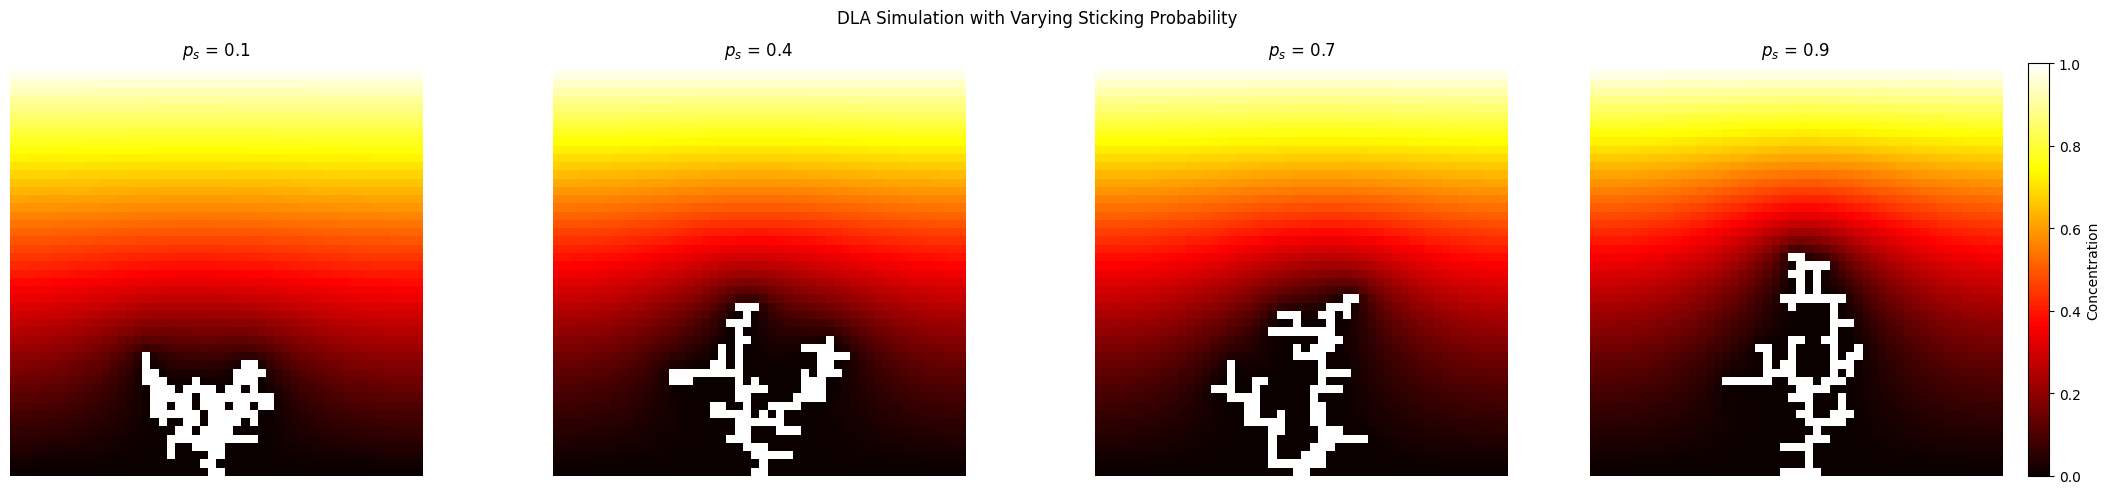

In [76]:
grid_size = 100
initial_grid = np.linspace(0, 1, grid_size).reshape((grid_size, 1)) # linear gradient in the y direction
initial_grid = np.repeat(initial_grid, grid_size, axis=1)
initial_objects = [(0,int(grid_size/2))]
growth_steps = 100
eta = 0.5 # changing this gives different object shapes
omega = 1.90 # optimal omega for grid size 50 from the previous assignment
sticking_probabilities = [0.1, 0.4, 0.7, 0.9]

fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for i, sp in enumerate(sticking_probabilities):
    final_state, final_objects = monte_carlo_DLA(initial_grid, grid_size, initial_objects, growth_steps, sp)
    for j in range(len(final_objects)):
        final_state[final_objects[j][0], final_objects[j][1]] = 1

    cax = axes[i].imshow(final_state, cmap='hot', interpolation='nearest', origin='lower')
    axes[i].set_title(f'$p_s$ = {sp}')
    axes[i].axis('off')
fig.colorbar(cax, ax=axes[i], label='Concentration')
plt.suptitle('DLA Simulation with Varying Sticking Probability')
plt.tight_layout()
plt.show()

## The Gray-Scott model - A reaction-diffusion system

In [122]:
def laplacian(Z,dx):
    """Compute the Laplacian of a 2D array Z using finite differences."""
    return (np.roll(Z, 1, axis=0) + np.roll(Z, -1, axis=0) +
            np.roll(Z, 1, axis=1) + np.roll(Z, -1, axis=1) - 4 * Z) / dx**2

def update(U, V, Du, Dv, dt, dx, f, k):
    """Update U and V according to the Gray-Scott model equations."""
    Uc = U.copy()
    Vc = V.copy()
    lapU = laplacian(Uc, dx)
    lapV = laplacian(Vc, dx)
    U += dt * (Du * lapU - Uc * Vc**2 + f * (1 - Uc))
    V += dt * (Dv * lapV + Uc * Vc**2 - (f + k) * Vc)
    return U, V

### 3.1 Plot for various initial conditions (size of center square) of V

In [150]:
# Model parameters
dt = 1.0  # Time step
dx = 1.0  # Space step
Du = 0.16  # Diffusion coefficient of U
Dv = 0.08  # Diffusion coefficient of V
f = 0.035  # Feed rate of U
k = 0.060  # Rate constant of the reaction V -> P

# System size and initial conditions
size = 100
center = size // 2
U1 = np.ones((size, size)) * 0.5
U2 = np.ones((size, size)) * 0.5
V1 = np.zeros((size, size))
V2 = np.zeros((size, size))
V1[center-10//2:center+10//2, center-10//2:center+10//2] = 0.25
V2[center-40//2:center+40//2, center-40//2:center+40//2] = 0.25

# Add noise
noise_level = 0.05
U1 += noise_level * np.random.rand(size, size)
U2 += noise_level * np.random.rand(size, size)
V1 += noise_level * np.random.rand(size, size)
V2 += noise_level * np.random.rand(size, size)

In [151]:
steps = 1000
for i in range(steps):
    U1_, V1_ = update(U1, V1, Du, Dv, dt, dx, f, k)
    U2_, V2_ = update(U2, V2, Du, Dv, dt, dx, f, k)

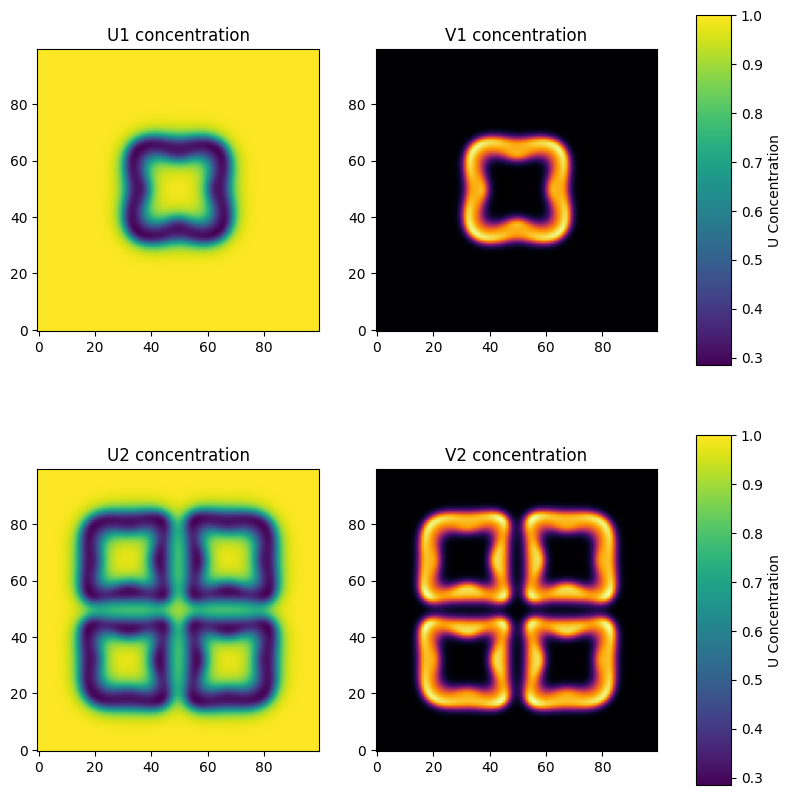

In [154]:
fig, axes = plt.subplots(2, 2, figsize=(10,10))

# Define min and max values for color normalization across all subplots
min_val_U = np.min([U1_, U2_])
max_val_U = np.max([U1_, U2_])
min_val_V = np.min([V1, V2])
max_val_V = np.max([V1, V2])

# U1, V1
cax1 = axes[0, 0].imshow(U1_, cmap='viridis', origin='lower', vmin=min_val_U, vmax=max_val_U)
axes[0, 1].imshow(V1, cmap='inferno', origin='lower', vmin=min_val_V, vmax=max_val_V)
axes[0, 0].set_title('U1 concentration')
axes[0, 1].set_title('V1 concentration')

# U2, V2
axes[1, 0].imshow(U2_, cmap='viridis', origin='lower', vmin=min_val_U, vmax=max_val_U)
axes[1, 1].imshow(V2, cmap='inferno', origin='lower', vmin=min_val_V, vmax=max_val_V)
axes[1, 0].set_title('U2 concentration')
axes[1, 1].set_title('V2 concentration')

# Common colorbars
fig.colorbar(cax1, ax=axes[0, :], location='right', aspect=10, label='U Concentration')
fig.colorbar(cax1, ax=axes[1, :], location='right', aspect=10, label='U Concentration')

plt.show()


### 3.2 